# Data from: https://github.com/ardamavi/Sign-Language-Digits-Dataset

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
from numpy import random

import keras
import tensorflow as tf
from keras import models
from tensorflow.keras.callbacks import TensorBoard

from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, Flatten, Dropout, Dense
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


## Define data path and sub files

In [51]:
data_path = ".\Dataset"
labels = ["0","1","2","3","4","5","6","7","8","9"]

## Random show an image from the data files

Class selection: 7
File from: .\Dataset\7\IMG_1125.JPG
Image Dims: (100, 100)


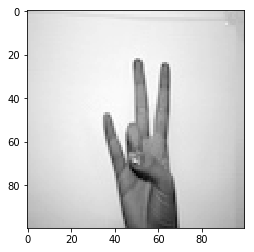

In [201]:
rand_img = random.choice(list(labels))
print("Class selection:",rand_img)
data_path1 = os.path.join(data_path, rand_img)

for img in os.listdir(data_path1):
    rand_img = random.choice(list(labels))
    image = cv2.imread(os.path.join(data_path1, img), cv2.IMREAD_GRAYSCALE)
    print("File from:",os.path.join(data_path1, img))
    print("Image Dims:", np.shape(image))
    plt.imshow(image, cmap="gray")
    break

## Log files settings for tensorboard

In [5]:
NAME = "sign_numbers_22"

In [6]:
tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

## Model definition , compile and print summary

In [7]:
multi_class_model = Sequential()

multi_class_model.add(Conv2D(36, (3, 3),input_shape = (64,64,1), activation='relu'))
multi_class_model.add(MaxPooling2D(pool_size = (2, 2)))

multi_class_model.add(Conv2D(24, (3, 3),activation='relu'))
multi_class_model.add(MaxPooling2D(pool_size = (4, 4)))

multi_class_model.add(Flatten())

multi_class_model.add(Dense(256, activation = 'relu'))
multi_class_model.add(Dropout(0.5))
multi_class_model.add(BatchNormalization())

multi_class_model.add(Dense(10, activation = 'softmax'))

multi_class_model.compile(optimizer=Adam(lr=0.001),loss = 'binary_crossentropy', metrics = ['accuracy'])

In [8]:
multi_class_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 36)        360       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 36)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 24)        7800      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 24)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1176)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               301312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
__________

# Train by using the ImageDataGenerator from Keras

## Data/images prep:

In [9]:
train_datagen = ImageDataGenerator(rescale = 1./255,rotation_range=15,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.01,
                                   zoom_range=[0.9, 1.25],
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode='reflect',
                                   brightness_range=[0.9, 1.5])

## File which contains all the data "directory=r"./Dataset" , divided with sub folders for each number [0,1,2 etc] it needs to be in this format or else it wont work

In [10]:
train_generator = train_datagen.flow_from_directory(
    directory=r"./Dataset",
    target_size=(64, 64),
    color_mode="grayscale",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 2062 images belonging to 10 classes.


# Start training

In [12]:
keras.backend.get_session().run(tf.global_variables_initializer())
# Not needed, but sometimes it gave me an error which i rat this cell to fix it

In [13]:
multi_class_model.fit_generator(train_generator,
                    steps_per_epoch = 64,
                    epochs = 20, callbacks=[tensorboard])

Epoch 1/20
64/64 [==============================] - 48s 745ms/step - loss: 0.3258 - acc: 0.8996
Epoch 2/20
64/64 [==============================] - 10s 157ms/step - loss: 0.2713 - acc: 0.9045
Epoch 3/20
64/64 [==============================] - 10s 150ms/step - loss: 0.2380 - acc: 0.9121
Epoch 4/20
64/64 [==============================] - 10s 150ms/step - loss: 0.2176 - acc: 0.9185
Epoch 5/20
64/64 [==============================] - 10s 151ms/step - loss: 0.2001 - acc: 0.9244
Epoch 6/20
64/64 [==============================] - 10s 149ms/step - loss: 0.1903 - acc: 0.9259
Epoch 7/20
64/64 [==============================] - 10s 150ms/step - loss: 0.1780 - acc: 0.9313
Epoch 8/20
64/64 [==============================] - 10s 150ms/step - loss: 0.1731 - acc: 0.9331
Epoch 9/20
64/64 [==============================] - 10s 150ms/step - loss: 0.1621 - acc: 0.9374
Epoch 10/20
64/64 [==============================] - 10s 152ms/step - loss: 0.1562 - acc: 0.9397
Epoch 11/20
64/64 [====================

## Save the model

In [14]:
multi_class_model.save(r'./Model/model_40_epoch.h5')

# Try the model predictions using camera using OpenCv

In [16]:
import cv2
import numpy as np
from PIL import Image
from keras import models

font = cv2.FONT_HERSHEY_SIMPLEX

model = models.load_model(r'./Model/model_40_epoch.h5')

video = cv2.VideoCapture(0)

def train_target_gen(image):
    
    image_array = np.asarray(image)
    image_array = cv2.resize(image, (64,64))
    image_array= (image_array/255)
    image_array = image_array.reshape(-1,64,64,1)

    yield (image_array)
    
while True:
    
    _, frame = video.read()
    im=cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    img_array = np.array(im)
    prediction = model.predict_generator(train_target_gen((img_array)), steps=1)
    y_classes = prediction.argmax(axis=-1)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (30,30)
    fontScale = 1
    fontColor = (255,255,255)
    lineType = 2
    cv2.putText(frame,str(y_classes), 
    bottomLeftCornerOfText, 
    font, 
    fontScale,
    fontColor,
    lineType)


    cv2.imshow("Capturing", frame)
    key=cv2.waitKey(1)
    if key ==ord('q'):
        break
video.release()
cv2.destroyAllWindows()

## It wont work 100% for live data , even if 95% acu and more. More research is needed